# Exercise Data Visualization

The objective of this mini-project is to analyze and visualize exercise data obtained from a personal wearable device that belongs to an individual named "Mike" (a pseudonym used to protect privacy). My goal is to gain insights into Mike's exercise routine, performance trends, and overall physical activity levels. This assignment aim to demonstrate the practical application of data visualization principles to real-world data by using various visualization techniques.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import folium
from folium import plugins
import datetime

%matplotlib inline

# Read in the strava.csv file containing a Mike's excercising data
df = pd.read_csv('assets/strava.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

## Preprocess DataFrame

In [9]:
def run_or_bike(df):
    # Process the original dataframe and determine running or cycling by the average speed.
    # for speed that is below 11000 meter per hour or 11kph will be classified as running, above 11000 will be cycling.
    
    # finding the total distance of each exercise. Since the distance value is cummulative. If we subtract the current distance value from
    # the ones in the previous row and resulted in negative value, it can be considered as the starting point of a new turn of exercise.
    df['diff'] = df['distance'].diff()
    df['marker'] = ((df['diff'] <0) | (df.index == 0)).astype(int)
    df['excercise_group'] = df['marker'].cumsum() 
    df['dist_per_exercise'] = df.groupby(df['excercise_group'])['distance'].transform(lambda x: x.max())
    
    # Find the time used(meters per hour) for each exercise.
    df['time_used_by_hour'] = df.groupby(df['excercise_group'])['timestamp'].transform(lambda x: max(x) - min(x))
    df['time_used_by_hour'] = df['time_used_by_hour'].dt.total_seconds() / 3600
    
    # find the average speed of each exercise and classify them into running or cycling according to the speed.
    df['speed_meter_per_hour'] = df['dist_per_exercise'] / df['time_used_by_hour']
    df.loc[df['speed_meter_per_hour'] <= 11000, 'run_or_bike'] = 'run'
    df.loc[df['speed_meter_per_hour'] > 11000, 'run_or_bike'] = 'bike'
    return df.drop(columns=['diff', 'marker'])

# Create a dataframe that labels entries with bike or run labels.
df = run_or_bike(df)


## 1. Graph 1 (Scatter Plot): Exploring the Correlation Relationship between Ground Time vs Cadence

###  Exploring Ground Time vs Cadence datasets 

17847

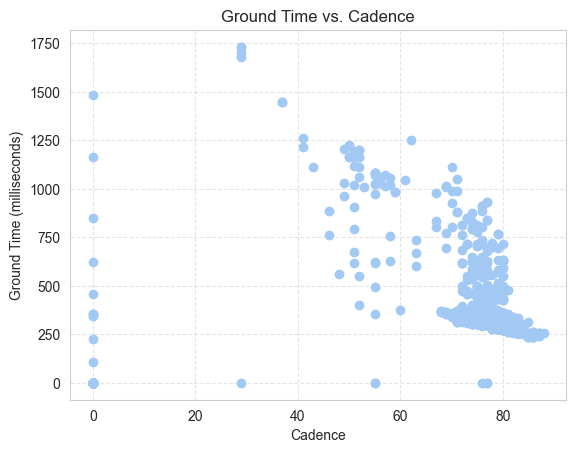

In [10]:
#plt.hist(df[df['run_or_bike']=='run']['Ground Time'], bins=50)
df_ground = df[df['run_or_bike']=='run'].dropna(subset='Ground Time')

plt.scatter(df_ground['Cadence'], df_ground['Ground Time'])

plt.title('Ground Time vs. Cadence')
plt.xlabel('Cadence')
plt.ylabel('Ground Time (milliseconds)')

#plt.xlim(min(df_ground['Cadence']), max(df_ground['Cadence']))
#plt.ylim(min(df_ground['Ground Time']), max(df_ground['Ground Time']))

plt.grid(True, linestyle='--', alpha=0.5)
len(df_ground)

### Plot Ground Time vs Cadence Scatter Plot

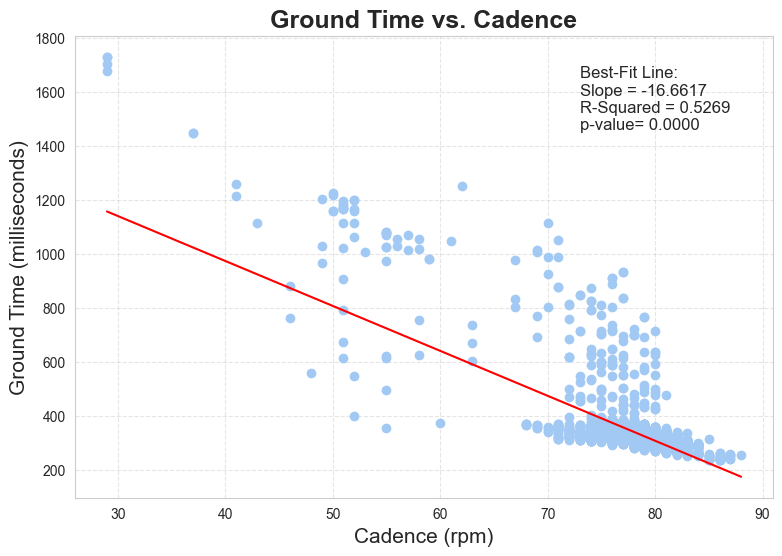

In [11]:
# Get rid of any entries with value zero for Ground Time or Cadence. As we can see from the graph above, these data were outliers
# They are suspected to be collected at the stopping or starting point of the running sessions.
df_ground1 = df_ground.loc[(df_ground['Ground Time']!=0.) & (df_ground['Cadence']!=0.)]

# Create scatter plot without the outliers.
plt.figure(figsize=(9,6))
sns.set_style("whitegrid")

plt.scatter(df_ground1['Cadence'], df_ground1['Ground Time'])

# Adjusting the titles and labels of the graph
plt.title('Ground Time vs. Cadence', fontsize=18, fontweight='bold')
plt.xlabel('Cadence (rpm)', fontsize=15)
plt.ylabel('Ground Time (milliseconds)', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)

# Calculate linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(df_ground1['Cadence'], df_ground1['Ground Time'])

# Overlay the linear regression line
x = np.array([min(df_ground1['Cadence']), max(df_ground1['Cadence'])])
y = slope * x + intercept
plt.plot(x, y, color='red')

# Add stats text to the plot
eqn = f'Best-Fit Line:\nSlope = {slope:.4f}\nR-Squared = {r_value**2:.4f}\np-value= {p_value:.4f}'
plt.text(73, 1450, eqn, ha='left', va='bottom', fontsize=12);

## Graph 1 Interpretation
According to an article from Healthline, increasing `Cadence` would help the exercised reduce their `Ground Time`  and improve his running efficiency. (Travis Edwards, 2021) A strong negative correlation between these variables could indicate that he runs in good form. 

The scatterplot above showed a negative correlation between `Cadence` and `Ground Time`, supported by the -16.67 slope and the red downward best-fit line. 0 p-value suggests that we are confident that the correlation is not zero and is negative in this case. However, the correlation is moderately correlated with a 0.526 R-squared value. Most data points clustered between 70 to 90 rpm of `Cadence` and 400 to 200 milliseconds of `Ground Time`. They are close to the negative sloped best-fit line. Above clustered data points, we can see a trend of outliers rose in Ground Time between 65 to 80 rpm. We can also see most of the outliers are above the best-fit line. The outliers where higher `Cadence` corresponds to longer `Ground Time` could suggest that Mike  might have muscle imbalances at those moments due to fatigue or other reasons. 

The moderate correlation and the fact that most outliers tend to have longer `Ground Time` indicated that there could be room for improvement to maintain a better and more efficient running form.

## 2. (Histogram):  Distribution of Form Power

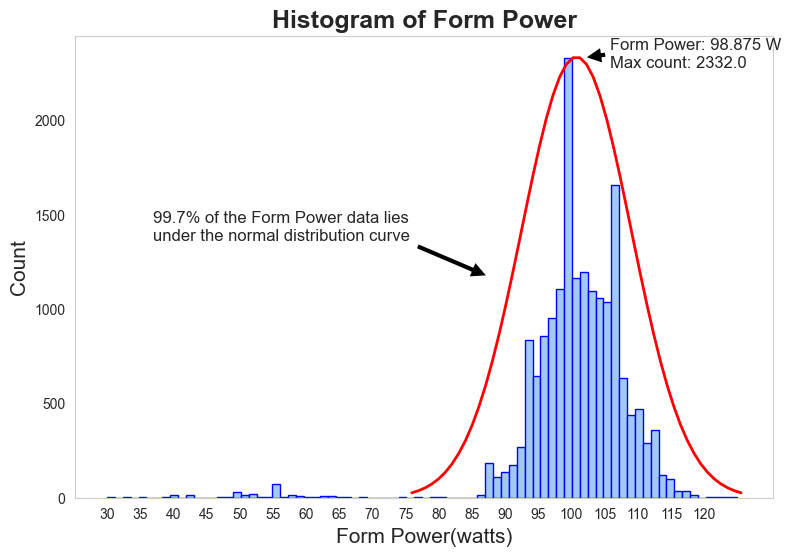

In [12]:
# Subset the dataset to drop Nan value in the Form Power column
df_power = df.dropna(subset='Form Power')

# Eliminate 0 Form Power readings because those can be data captured when the runner stops or rests.
df_power = df_power.loc[df_power['Form Power']!=0]
df_power = df_power.sort_values(by='timestamp')

# Used subplot to make a larger histogram graph
plt.figure(figsize=(9,6))
sns.set_style("whitegrid")
y_count, bins, patch = plt.hist(df_power['Form Power'], bins=80, edgecolor='b')

# Get stats values of the form power, highest value, mean, and std
max_count_index = y_count.argmax()
mean = np.mean(df_power['Form Power'])
std = np.std(df_power['Form Power'])

# Set the normal distribution curve covering 3 standard deviations away from the mean
x = np.linspace(mean-3*std, mean+3*std)

# Used probability distribution function to generate the curve
pdf = stats.norm.pdf(x, mean, std)
pdf = pdf / pdf.max() * y_count.max()
plt.plot(x, pdf, linewidth=2, color='red')

# Annotate the most frequent Form power value in the histogram. 
arrow1 = plt.annotate(f'Form Power: {bins[max_count_index]} W\nMax count: {y_count[max_count_index]}', 
                     xy=(
                         bins[max_count_index]+3, 
                         y_count[max_count_index]
                     ), 
                     xytext=(
                        bins[max_count_index]+7, 
                        y_count[max_count_index]-50
                    ), 
                     arrowprops=dict(
                         facecolor='black', 
                         shrink=0.05
                     ),
                     fontsize=12
                    )

# Annotate a description for the data under the normal distribution curve.
arrow2 = plt.annotate('99.7% of the Form Power data lies\nunder the normal distribution curve', 
            xy=(
                np.min(x)+12, 
                y_count.max()/2 
               ), 
            xytext=(
                np.min(x)-39, 
                (y_count.max()/2) + 200
                
            ), 
            arrowprops=dict(
                facecolor='black', 
                shrink=0.05                
            ),
            fontsize=12
           )

# Adjusting the plot for better readability while including as many info as possible.
plt.grid(False)
plt.xticks(np.arange(min(df_power['Form Power']), max(df_power['Form Power']), 5))
plt.xlabel('Form Power(watts)', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Histogram of Form Power', fontsize=18, fontweight='bold');

## Graph 2 Interpretation
The graph above is a histogram depicting the distribution of the form power data when Mike was running. This power output measured how much effort and intensity of the exercise.(Polar,2022)

In this histogram, the x-axis represented the range of form power output, and the y-axis represented the count of how many times each power output occurred. The graph shows that most of the data points were clustered around 75watts to 120watts. The most frequent power output was 98.875 Watts. In addition, most of the data(about 99.7% of the data) follows a bell-shaped curve, which means they are evenly distributed around the mean. This even distribution of the form power could indicate that Mike was consistent in his power output and running at a steady and balanced workout. The outliers primarily lie on the left side of the plot. The lower power outputs could have resulted from the runner warming up, slowing down or simply running efficiently at that particular moment. Investigating these outliers may provide helpful insights for increasing running efficiency.

## 3. Violin Plot: Distribution of Heart Rates between Running and Cycling

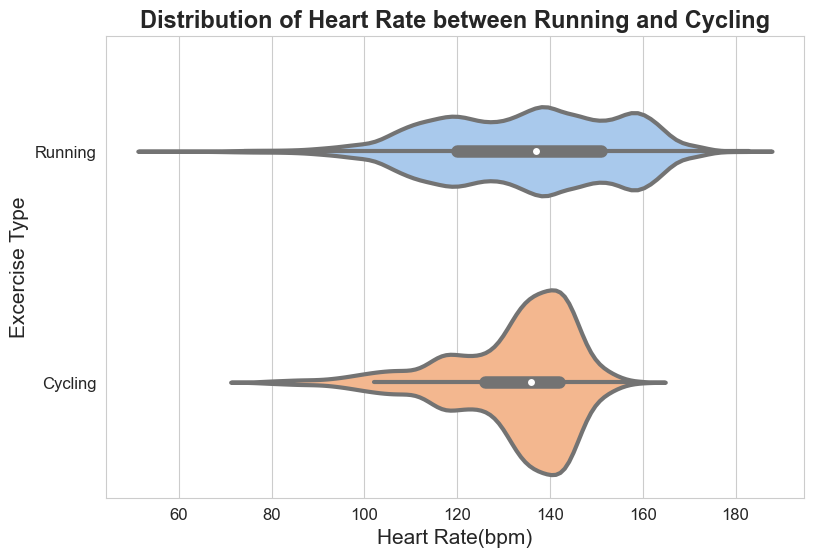

In [13]:
# Subset data frame by dropping any Nan value from heart rate column
df_heart = df.dropna(subset='heart_rate')

# Set style and size of the plot
plt.figure(figsize=(9, 6))
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Create the violin plot for univariable heart_rate in two groups, cycling and running.
ax = sns.violinplot(x='heart_rate', y='run_or_bike', data=df_heart, saturation=0.8, inner='box', linewidth=3)

# Adjust the label, ticks and titles
plt.xlabel('Heart Rate(bpm)', fontsize=15)
plt.ylabel('Excercise Type', fontsize=15)
plt.title('Distribution of Heart Rate between Running and Cycling', fontsize=17, fontweight='bold')
plt.gca().set_yticklabels(['Running', 'Cycling'], fontsize=12)
ax.tick_params(axis='x', labelsize=12)



## Graph 3 Interpretation:
I have constructed a violin plot with running and cycling on the y-axis and the heart rate on the x-axis. The violin plot visualization can give us an intuition on a person's most common heart rate during those two exercises and the distribution of his heart rates. 

From the graph, we can see Mike have similar median heart rates during either cycling or running. However, he tends to have higher maximum and lower minimum heart rates when running. The longer tails of the violin plot and bigger interquartile box indicate a wider range and more variance in his heart rates during running. In contrast, the heart rate distribution for cycling is narrower than for running, indicating less variability in heart rates. In other words, cycling can help Mike maintain a more consistent heart rate at around 140 bpm, while running introduces more fluctuations in heart rates. Finally, there appear to be some outliers in heart rate distribution for running on the lower end. Further investigation on these outliers is needed to determine wheater it is a potential health issue or sensor malfunction.

## 4. Time-lapse Heatmap: Running Routes with Heart Rate Intensity

In [14]:
# Subset the running entries from the dataframe. Drop NaN value from latitude, longitude, and heart_rate column. Scale the heart_rate
# values to percentage for weight parameter in folium.plugin.HeatMapWithTime() function.
df_run = df[df['run_or_bike']=='run']
df_run = df_run.dropna(subset=['position_lat', 'position_long', 'heart_rate']).reset_index()
df_run['heart_scaled'] = df_run['heart_rate'] / np.max(df_run['heart_rate'])

# Convert the latitude and longitude values
df_run['lat'] = df_run['position_lat'] * ( 180 / 2**31 )
df_run['lon'] = df_run['position_long'] * ( 180 / 2**31 )

# Group timestamp by minute
groups = df_run.groupby(pd.Grouper(key='timestamp', freq='Min'))

# Loop through each minute group
weight = []
for name, group in groups:
    # The number of the outter lists represents the number of minutes. 
    # Create temperary list to hold the value
    temp=[]
    # Loop through each entry in the current group to extract lat, lon and heart_rates value corresponding to the data parameter
    # for folium.plugin.HeatMapWithTime() function
    for index, row in group.iterrows():
        lat = row['lat']
        lon = row['lon']
        value = row['heart_scaled']
        temp.append([lat,lon,value])
    if temp:
        weight.append(temp)

# Convert the timestamp value into a list to be used as the index for folium heatmap.
min_time = np.sort(df_run['timestamp'].unique())
min_arr = np.array([np.datetime_as_string(dt, unit='m') for dt in min_time])
min_list = min_arr.tolist()

In [17]:
# Check lengths
print("Length of data:", len(weight))
print("Length of index:", len(min_list))

if len(weight) > len(min_list):
    weight = weight[:len(min_list)]
elif len(min_list) > len(weight):
    min_list = min_list[:len(weight)]

# After adjustment, retry adding the heatmap to the map
try:
    plugins.HeatMapWithTime(weight, index=min_list, gradient={0.25: 'blue', 0.99: 'lime', 1: 'red'}, radius=20, auto_play=True, position='bottomright', min_opacity=0.5, max_opacity=0.9).add_to(m)
    display(m)
except ValueError as e:
    print("Error:", e)

Length of data: 1471
Length of index: 32593


## Graph 4 Interpretation

For the last graph, I generate a folium time-lapse heatmap that shows a Mike's exercise locations as well as the intensity of heart rates between each time interval, which is 1 minute in this graph. It is an interactive graph where you can auto-play or manually change the frame to see the location of the data collected and the heart rate intensity represented by a circular heatmap. One can also zoom in or out to view the map from a different perspective.

The heart rate values are used as weights in this heatmap because the heatmap can provide some insights into how heart rate values vary between time intervals. For example, I manually set the gradient parameter to 0.99 for the second to last color, so when the red area of the circle increase, it would indicate that the heart rates value is more intensive at that time frame and could suggest that the location is associated with more intense physical activity or higher exertion. Alternatively, a lower heart rate could indicate a lower intensity of activity.

However, since this is a heatmap, the comparison would vary at different zoom levels, so it would be best to compare it at the same zoom scale. It would also be helpful if there were more data, so a more extensive time interval with mean or other statistical summary values could be used as the weight to better visualize the change in heart rate at different locations.